In [1]:
import os 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import LeakyReLU
import tensorflow_datasets as tdfs
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
(train_images2, train_labels2), (test_images2, test_labels2) = datasets.cifar100.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images2, test_iamges2 = train_images2 / 255.0, test_images2 / 255.0


train_images = np.concatenate((train_images, train_images2) ,axis=0)
test_images = np.concatenate((test_images, test_images2), axis=0)

train_labels = np.concatenate((train_labels, train_labels2), axis=0)# Data Augmentation

rot90 = np.rot90(train_images,axes=(1,2))
rot180 = np.rot90(train_images,k=2,axes=(1,2))
rot270 = np.rot90(train_images,k=3,axes=(1,2))

train_images_pro = np.concatenate((train_images, rot90) ,axis=0)
train_images_pro.shape

# train_images_pro_max = np.concatenate((train_images_pro, rot180, rot270) ,axis=0)
# train_images_pro.shape

(200000, 32, 32, 3)

In [3]:
def residual_loss(y_true, y_pred):
    B = batch_size
    s = B * H * W * C
    n = 1 # corresponds to iterations of the network
    beta = 1 / (s * n)
    
    summation = tf.math.reduce_sum(tf.math.abs(tf.math.subtract(y_true, y_pred)), [0,1,2,3])
    return tf.math.square(beta * summation)

def SSIMLoss(y_true, y_pred):
    return tf.math.square(1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0)))

def PSNRLoss(y_true, y_pred,max_val=1.0):
    return tf.math.square(tf.image.psnr(y_true, y_pred, max_val=max_val))

def SSIM_res_loss(y_true, y_pred):
    return SSIMLoss(y_true, y_pred) + residual_loss(y_true, y_pred) + PSNRLoss(y_true, y_pred)

def test_model(model, test_images, indexes=np.arange(5)):
    img_preds = model.predict(test_images[indexes])
    
    plt.figure(figsize=(10,10))
    for i in indexes:
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.show()

    plt.figure(figsize=(10,10))
    for i in indexes:
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_preds[i], cmap=plt.cm.binary)
    plt.show()
    
def plot_metric(history, metric='val_SSIMLoss'):
    import matplotlib.pyplot as plt
    plt.plot(history.history[metric])

def save_model(model, path):
    model.save(path)
    print(f'Model saved to: {path}.')
    
def load_model(path, custom_objects):
    '''
    path is the directory containing a "saved_model.pb" - E.g. path=models/new_model"
    Custom objects must be any user-defined loss functions. E.g. {'SSIMLoss': SSIMLoss, 'PSNRLoss': PSNRLoss, 'residual_loss': residual_loss}
    '''
    return tf.keras.models.load_model(path, custom_objects=custom_objects)

def save_history(history, path, identifier=''):

    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to csv: 
    hist_csv_file = f'{path}/history_{identifier}.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [4]:
def get_model(iterations):
    
    model = tf.keras.Sequential() 

    for i in range(iterations):

        model.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), strides = (2, 2), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),   padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(layers.Conv2D(filters=32, kernel_size=1,  strides = (1,1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(layers.Conv2D(filters=512, kernel_size=1,  strides = (1,1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))

        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=512, kernel_size=2, strides=(1, 1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))


        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

        model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
        model.add(layers.ConvLSTM2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NHWC')))

        model.add(layers.Conv2D(filters=3, kernel_size=1, strides = (1,1), padding='same', data_format='channels_last'))
        model.add(LeakyReLU(alpha=0.1))
        
    opt = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, 
                                   beta_1=0.9, beta_2=0.999, 
                                   epsilon=1e-06, amsgrad=True)
    
    model.compile(optimizer=opt, 
                  loss=SSIMLoss, 
                  metrics=[SSIMLoss, PSNRLoss, residual_loss, "mae", "acc"])
        
    return model

In [5]:
epochs=10
iterations = 1
batch_size = 512
H = train_images.shape[1]
W = train_images.shape[2]
C = train_images.shape[3]
initial_learning_rate = 0.01
validation_split=0.05

model = get_model(iterations=1)
# model.summary()

In [6]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=1*batch_size)

decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)


model_history = model.fit(train_images, train_images, 
                          batch_size=batch_size, 
                          epochs=epochs, 
                          validation_split=validation_split, 
                          callbacks=[cp_callback])



# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))



Epoch 1/10
186/186 [==============================] - 155s 834ms/step - loss: 0.4268 - SSIMLoss: 0.4265 - PSNRLoss: 180.0288 - residual_loss: 0.0411 - mae: 0.1958 - acc: 0.4856 - val_loss: 0.3058 - val_SSIMLoss: 0.3060 - val_PSNRLoss: 194.9975 - val_residual_loss: 0.0273 - val_mae: 0.1689 - val_acc: 0.5151
Epoch 2/10
186/186 [==============================] - 155s 836ms/step - loss: 0.2186 - SSIMLoss: 0.2185 - PSNRLoss: 245.8459 - residual_loss: 0.0185 - mae: 0.1361 - acc: 0.4935 - val_loss: 0.1704 - val_SSIMLoss: 0.1706 - val_PSNRLoss: 258.8814 - val_residual_loss: 0.0159 - val_mae: 0.1287 - val_acc: 0.4815
Epoch 3/10
139/186 [=====================>........] - ETA: 38s - loss: 0.1449 - SSIMLoss: 0.1449 - PSNRLoss: 272.2214 - residual_loss: 0.0150 - mae: 0.1226 - acc: 0.4672
Epoch 00003: saving model to weights/cp-0003.ckpt
186/186 [==============================] - 162s 869ms/step - loss: 0.1409 - SSIMLoss: 0.1408 - PSNRLoss: 273.3990 - residual_loss: 0.0149 - mae: 0.1221 - acc: 0.465

In [7]:
test_model(loaded_model, test_images)

NameError: name 'loaded_model' is not defined

In [20]:
path = 'ssim_resid_psnr/models'
save_model(model, path)

INFO:tensorflow:Assets written to: ssim_resid_psnr/models/assets
Model saved to: ssim_resid_psnr/models.


In [8]:
custom_objects = {'SSIMLoss': SSIMLoss, 'PSNRLoss': PSNRLoss, 'residual_loss': residual_loss, 'SSIM_res_loss': SSIM_res_loss}
loaded_model = load_model(path, custom_objects)

In [22]:
save_history(model_history, path='ssim_resid_psnr/history', identifier='000')

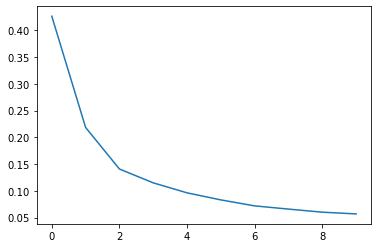

In [8]:
plot_metric(model_history, 'SSIMLoss')

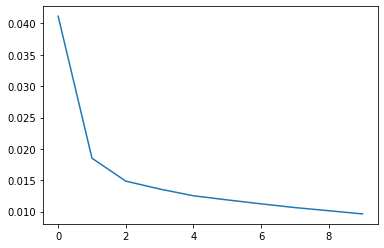

In [9]:
plot_metric(model_history, 'residual_loss')

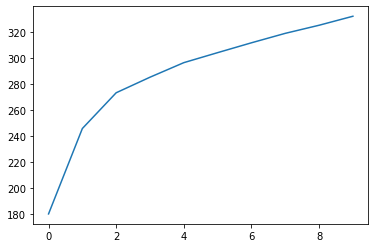

In [10]:
plot_metric(model_history, 'PSNRLoss')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


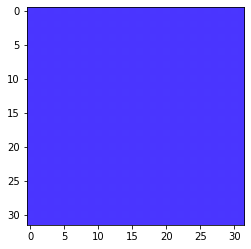

In [19]:
img_preds2 = model.predict(test_images[0:1])
plt.imshow(img_preds2[])